# Marathi Tweet Sentiment Analysis with SentiWordNet

This notebook combines two Marathi sentiment datasets (MahaSent Movie Reviews and MahaSent Social Tweets), translates Marathi text to English, applies a rule-based sentiment classifier using SentiWordNet, evaluates performance, and visualizes results with word clouds and confusion matrices.

## Pipeline Overview
1. Load and unify datasets (movie reviews + social tweets)
2. Clean and deduplicate
3. Translate Marathi → English with caching
4. Tokenize and score using SentiWordNet
5. Predict sentiment labels (positive / negative / neutral)
6. Evaluate against gold labels
7. Visualize (word clouds, label distributions, confusion matrix)
8. Save merged results, metrics, artifacts

## Why Rule-Based First?
Using SentiWordNet provides a transparent baseline. Later you can compare with ML models (Naive Bayes, SVM) or transformer-based IndicBERT / mBERT fine-tuning.

---
**Note:** Translation quality affects downstream scoring; idioms or domain phrases may reduce accuracy. Caching limits repeated API usage.

In [1]:
# =====================
# 1. Setup: Imports & Configuration
# =====================
import os
import re
import json
import time
import math
import random
from pathlib import Path
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import nltk
from nltk.corpus import sentiwordnet as swn, stopwords, wordnet
from nltk import pos_tag, word_tokenize

from deep_translator import GoogleTranslator

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# Ensure reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Translation & caching configuration
BLOCK_SIZE = 25            # number of rows per translation batch
CACHE_SAVE_INTERVAL = 100  # persist cache every N new translations
TRANSLATION_CACHE_PATH = Path('translation_cache.json')
OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(exist_ok=True)

# NLTK data download (fixed resource discovery)
nltk_resources = ["punkt", "wordnet", "sentiwordnet", "stopwords", "omw-1.4"]
for resource in nltk_resources:
    try:
        # Check for each resource type properly
        if resource == "punkt":
            nltk.data.find('tokenizers/punkt')
        elif resource in ["wordnet", "sentiwordnet", "omw-1.4"]:
            nltk.data.find(f'corpora/{resource}')
        elif resource == "stopwords":
            nltk.data.find('corpora/stopwords')
    except LookupError:
        try:
            print(f"Downloading {resource}...")
            nltk.download(resource, quiet=True)
        except Exception as e:
            print(f"Warning: could not download {resource}: {e}")

# Mapping now supports numeric labels (-1,0,1) commonly used in datasets
MARATHI_LABEL_NORMALIZATION = {
    'pos': 'positive', 'positive': 'positive', '1': 'positive',
    'neg': 'negative', 'negative': 'negative', '-1': 'negative',
    'neu': 'neutral', 'neutral': 'neutral', '0': 'neutral'
}

# Initialize stopwords safely
try:
    EN_STOPWORDS = set(stopwords.words('english'))
    # Keep negations
    NEGATION_WORDS = {"not", "no", "never", "n't"}
    EN_STOPWORDS = {w for w in EN_STOPWORDS if w not in NEGATION_WORDS}
except Exception as e:
    print(f"Warning: Could not load stopwords: {e}")
    EN_STOPWORDS = set()

print("Setup complete. Updated label mapping supports -1/0/1.")

Setup complete. Updated label mapping supports -1/0/1.


## Load & Inspect Datasets
We automatically detect the MahaSent movie review and social tweet datasets (train/val/test CSV files) and unify them.

Steps:
- Search for files containing `MahaSent_MR_` and `MahaSent_ST_`
- Accept `.csv`, fallback to `.tsv` or `.txt` with common delimiters
- Standardize columns to: `text` (Marathi) and `label`
- Normalize label values to {positive, negative, neutral}
- Drop duplicates / empty rows
- Report dataset statistics

In [2]:
# =====================
# 2. Load Datasets
# =====================

SEARCH_ROOT = Path('.')

CANDIDATE_PATTERNS = [
    ('MR', 'MahaSent_MR_'),
    ('MS', 'MahaSent_ST_')
]

VALID_EXTS = ['.csv', '.tsv', '.txt']
DELIMS = [',', '\t', '|', ';']


def discover_files():
    files = {k: [] for k, _ in CANDIDATE_PATTERNS}
    for k, pattern in CANDIDATE_PATTERNS:
        try:
            for p in SEARCH_ROOT.rglob(f"{pattern}*"):
                if p.suffix.lower() in VALID_EXTS and p.is_file():
                    files[k].append(p)
        except Exception as e:
            print(f"Warning: Error searching for pattern {pattern}: {e}")
    return files


def try_read(path: Path):
    """Try to read a file with different delimiters and encodings."""
    encodings = ['utf-8', 'utf-8-sig', 'latin-1', 'cp1252']
    
    for encoding in encodings:
        for d in DELIMS:
            try:
                df = pd.read_csv(path, delimiter=d, encoding=encoding)
                if df.empty:
                    continue
                if df.shape[1] > 15:  # defensive: skip obviously wrong delimiter
                    continue
                if df.shape[0] > 0:  # ensure we have data
                    print(f"Successfully read {path} with delimiter '{d}' and encoding '{encoding}'")
                    return df
            except Exception as e:
                continue
    print(f"Failed to read {path} with any delimiter/encoding combination")
    return None


def standardize(df: pd.DataFrame, source_file: Path):
    """Standardize dataframe columns and handle various label formats."""
    if df is None or df.empty:
        return pd.DataFrame(columns=['text', 'label', 'label_raw', 'source'])
    
    cols_lower = {c.lower(): c for c in df.columns}
    
    # Find text column
    text_col = None
    text_candidates = ['text', 'tweet', 'review', 'sentence', 'comment', 'marathi_text', 'marathi_sentence']
    for cand in text_candidates:
        if cand in cols_lower:
            text_col = cols_lower[cand]
            break
    if text_col is None:
        text_col = df.columns[0]
        print(f"Warning: Using first column '{text_col}' as text for {source_file}")
    
    # Find label column
    label_col = None
    label_candidates = ['label', 'sentiment', 'polarity', 'class']
    for cand in label_candidates:
        if cand in cols_lower:
            label_col = cols_lower[cand]
            break
    if label_col is None and len(df.columns) > 1:
        label_col = df.columns[1]
        print(f"Warning: Using second column '{label_col}' as label for {source_file}")
    
    # Create standardized dataframe
    try:
        out = pd.DataFrame({'text': df[text_col].astype(str)})
        
        if label_col and label_col in df.columns:
            out['label_raw'] = df[label_col].astype(str).str.strip()
            out['label'] = out['label_raw'].apply(lambda x: x.lower() if re.search('[A-Za-z]', x) else x)
            out['label'] = out['label'].map(MARATHI_LABEL_NORMALIZATION)
        else:
            out['label_raw'] = np.nan
            out['label'] = np.nan
            print(f"Warning: No label column found for {source_file}")
        
        return out
    except Exception as e:
        print(f"Error standardizing {source_file}: {e}")
        return pd.DataFrame(columns=['text', 'label', 'label_raw'])


# Discover and load files
files_found = discover_files()
print('Discovered files:')
for k, v in files_found.items():
    for f in v:
        print(f"  [{k}] {f}")

if not any(files_found.values()):
    print("Warning: No dataset files found. Searching current directory structure...")
    # List directories for debugging
    for item in SEARCH_ROOT.iterdir():
        if item.is_dir():
            print(f"  Directory: {item}")

frames = []
for k, paths in files_found.items():
    for p in paths:
        try:
            df_raw = try_read(p)
            if df_raw is None:
                print(f"Could not read {p}")
                continue
            
            df_std = standardize(df_raw, p)
            if df_std.empty:
                print(f"Warning: Standardized dataframe is empty for {p}")
                continue
                
            df_std['source'] = k
            frames.append(df_std)
            print(f"Loaded {len(df_std)} rows from {p}")
            
        except Exception as e:
            print(f"Error processing {p}: {e}")

if not frames:
    print("Warning: No datasets loaded. Creating sample data for testing...")
    # Create sample data for development/testing
    sample_data = pd.DataFrame({
        'text': ['यह फिल्म बहुत अच्छी है', 'मुझे यह पसंद नहीं आया', 'ठीक है'],
        'label': ['positive', 'negative', 'neutral'],
        'label_raw': ['positive', 'negative', 'neutral'],
        'source': ['sample']
    })
    frames = [sample_data]
    print("Created sample dataset with 3 rows")

merged = pd.concat(frames, ignore_index=True)

# Clean data
print(f"Dataset size before cleaning: {len(merged)}")
merged['text'] = merged['text'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
merged = merged[merged['text'].str.len() > 0]
merged = merged.drop_duplicates(subset=['text'])

print(f'Dataset size after cleaning: {len(merged)}')
print('Label distribution (raw mapped):')
print(merged['label'].value_counts(dropna=False))
print('Source distribution:')
print(merged['source'].value_counts(dropna=False))

# Save combined (Marathi only) dataset early
# Ensure output dir exists (in case this cell run before setup accidentally)
if 'OUTPUT_DIR' not in globals():
    OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(exist_ok=True)

combined_path = OUTPUT_DIR / 'combined_marathi_dataset.csv'
try:
    merged.to_csv(combined_path, index=False, encoding='utf-8')
    print(f'Saved combined dataset (before translation) to: {combined_path}')
except Exception as e:
    print(f"Error saving combined dataset: {e}")

merged.head()

Discovered files:
  [MR] MahaSent_MR_Train.csv
  [MR] L3Cube_MahaSent_MR\MahaSent_MR_Test.csv
  [MR] L3Cube_MahaSent_MR\MahaSent_MR_Train.csv
  [MR] L3Cube_MahaSent_MR\MahaSent_MR_Val.csv
  [MS] L3Cube_MahaSent_MS\MahaSent_ST_Test.csv
  [MS] L3Cube_MahaSent_MS\MahaSent_ST_Train.csv
  [MS] L3Cube_MahaSent_MS\MahaSent_ST_Val.csv
Successfully read MahaSent_MR_Train.csv with delimiter ',' and encoding 'utf-8'
Loaded 12000 rows from MahaSent_MR_Train.csv
Successfully read L3Cube_MahaSent_MR\MahaSent_MR_Test.csv with delimiter ',' and encoding 'utf-8'
Loaded 1500 rows from L3Cube_MahaSent_MR\MahaSent_MR_Test.csv
Successfully read L3Cube_MahaSent_MR\MahaSent_MR_Train.csv with delimiter ',' and encoding 'utf-8'
Loaded 12000 rows from L3Cube_MahaSent_MR\MahaSent_MR_Train.csv
Successfully read L3Cube_MahaSent_MR\MahaSent_MR_Val.csv with delimiter ',' and encoding 'utf-8'
Loaded 1500 rows from L3Cube_MahaSent_MR\MahaSent_MR_Val.csv
Successfully read L3Cube_MahaSent_MS\MahaSent_ST_Test.csv with de

,text,label_raw,label,source
0,माने यांचा घटस्फोट झाला आहे तर मोहितेने नुकतेच...,-1,negative,MR
1,एका रात्रीत घडणारी किंबहुना बिघडणारी ही गोष्ट आहे,-1,negative,MR
2,जरी आघात समजण्यायोग्य आहे जरी चित्रपटाला खराब ...,-1,negative,MR
3,पण तो असा आघातही अनुभवत आहे की तो कोणाशीही शेअ...,-1,negative,MR
4,छोटे-छोटे गैरसमज मोठ्या अडचणीत येतात,-1,negative,MR


## Translate Marathi → English
We translate texts using `deep_translator.GoogleTranslator` with caching to avoid redundant API calls. Translation is performed in batches with retry logic.

Caching strategy:
- Load existing JSON cache if present
- Only translate missing Marathi strings
- Persist cache every N new translations (`CACHE_SAVE_INTERVAL`)

Handles failures by storing a placeholder token and marking a `translation_ok` flag.

### Domain-Balanced Combination (New)
To reduce underfitting/overfitting when merging Movie Reviews (MR) and Subtitles/Tweets (MS):
- We keep class balance AND source balance.
- For each (label, source) pair we sample up to the minimum available across sources (per label) so both domains contribute equally.
- We then create a stratified split that preserves both sentiment label distribution and domain proportion.
You can adjust the `BALANCE_MODE` variable to switch strategies:
- `strict`: enforce equal counts per (label, source)
- `proportional`: keep natural frequencies (original merged)
- `none`: skip balancing (raw merged)
The balanced dataset and splits will be saved under `output/combined_dataset/`. This helps avoid a model overfitting to wording style of the larger source.

In [4]:
# =====================
# 3. Translation with Caching
# =====================

def load_cache(path: Path):
    """Load translation cache from JSON file."""
    if path.exists():
        try:
            with open(path, 'r', encoding='utf-8') as f:
                cache = json.load(f)
                return cache
        except (json.JSONDecodeError, UnicodeDecodeError) as e:
            print(f"Failed to load cache (corrupted): {e}")
            # Backup corrupted cache
            backup_path = path.with_suffix('.backup.json')
            if path.exists():
                path.rename(backup_path)
                print(f"Moved corrupted cache to {backup_path}")
        except Exception as e:
            print(f"Failed to load cache: {e}")
    return {}


def save_cache(cache: dict, path: Path):
    """Safely save translation cache to JSON file."""
    try:
        # Create directory if it doesn't exist
        path.parent.mkdir(parents=True, exist_ok=True)
        
        # Use temporary file for atomic write
        tmp = path.with_suffix('.tmp')
        with open(tmp, 'w', encoding='utf-8') as f:
            json.dump(cache, f, ensure_ascii=False, indent=2)
        tmp.replace(path)
        return True
    except Exception as e:
        print(f"Failed to save cache: {e}")
        return False


def safe_translate(translator, text, max_retries=3):
    """Safely translate text with retry logic and error handling."""
    if not text or not isinstance(text, str) or len(text.strip()) == 0:
        return "<empty_text>", False
    
    # Skip if text is too long (Google Translate has limits)
    if len(text) > 5000:
        return "<text_too_long>", False
    
    attempt = 0
    backoff = 2
    
    while attempt < max_retries:
        try:
            # Add small delay to respect rate limits
            if attempt > 0:
                time.sleep(backoff)
            
            result = translator.translate(text)
            
            if result is None:
                raise Exception("Translation returned None")
            
            if not isinstance(result, str):
                result = str(result)
            
            # Clean up the result
            result = re.sub(r'\s+', ' ', result).strip()
            
            if len(result) == 0:
                return "<empty_translation>", False
            
            return result, True
            
        except Exception as e:
            attempt += 1
            if attempt >= max_retries:
                error_msg = str(e)[:100]  # Truncate long error messages
                return f"<translation_failed: {error_msg}>", False
            else:
                backoff *= 2
                print(f"Translation attempt {attempt} failed for text '{text[:50]}...': {e}")
    
    return "<max_retries_exceeded>", False


# Load existing cache
translation_cache = load_cache(TRANSLATION_CACHE_PATH)
print(f"Loaded {len(translation_cache)} cached translations")

# Initialize translator
try:
    translator = GoogleTranslator(source='auto', target='en')
    print("GoogleTranslator initialized successfully")
except Exception as e:
    print(f"Error initializing GoogleTranslator: {e}")
    print("Translation will be skipped")
    translator = None

# Find texts that need translation
if translator is not None:
    missing_texts = [t for t in merged['text'] if t not in translation_cache and pd.notna(t)]
    print(f"Need to translate: {len(missing_texts)} new entries")
    
    if missing_texts:
        new_counter = 0
        total_translated = 0
        
        for i in tqdm(range(0, len(missing_texts), BLOCK_SIZE), desc='Translating'):
            batch = missing_texts[i:i+BLOCK_SIZE]
            
            for mar_txt in batch:
                if mar_txt in translation_cache:
                    continue
                
                # Translate text
                eng, success = safe_translate(translator, mar_txt)
                
                # Store result
                translation_cache[mar_txt] = {
                    "english": eng,
                    "ok": success,
                    "timestamp": time.time()
                }
                
                total_translated += 1
                new_counter += 1
                
                # Save cache periodically
                if new_counter >= CACHE_SAVE_INTERVAL:
                    if save_cache(translation_cache, TRANSLATION_CACHE_PATH):
                        print(f"Intermediate cache saved ({len(translation_cache)} entries)")
                    new_counter = 0
                
                # Small delay to be respectful to the API
                time.sleep(0.1)
        
        print(f"Translated {total_translated} new texts")
    else:
        print("All texts already cached!")
else:
    print("Skipping translation due to translator initialization error")
    # Create dummy entries for texts not in cache
    for text in merged['text']:
        if text not in translation_cache and pd.notna(text):
            translation_cache[text] = {
                "english": f"<no_translation_available>",
                "ok": False,
                "error": "translator_not_available"
            }

# Final cache save
if save_cache(translation_cache, TRANSLATION_CACHE_PATH):
    print(f"Final cache saved: {len(translation_cache)} total entries")

# Apply translations to dataset
merged['english_text'] = merged['text'].map(
    lambda x: translation_cache.get(x, {}).get('english', '<not_translated>')
)
merged['translation_ok'] = merged['text'].map(
    lambda x: translation_cache.get(x, {}).get('ok', False)
)

# Report translation statistics
success_count = merged['translation_ok'].sum()
total_count = len(merged)
print(f"Translation success rate: {success_count}/{total_count} ({success_count/total_count*100:.1f}%)")

print('\nSample translations:')
sample_data = merged[['text', 'english_text', 'translation_ok']].head()
for idx, row in sample_data.iterrows():
    print(f"Original: {row['text']}")
    print(f"English:  {row['english_text']}")
    print(f"Success:  {row['translation_ok']}")
    print("---")

Loaded 24062 cached translations
GoogleTranslator initialized successfully
Need to translate: 5938 new entries


Translating:   0%|          | 0/238 [00:00<?, ?it/s]

Translation attempt 1 failed for text '"जेव्हा मला वाटले की मी बाहेर आहे, तेव्हा त्यांनी ...': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries exceeded with url: /m?tl=en&sl=auto&q=%22%E0%A4%9C%E0%A5%87%E0%A4%B5%E0%A5%8D%E0%A4%B9%E0%A4%BE+%E0%A4%AE%E0%A4%B2%E0%A4%BE+%E0%A4%B5%E0%A4%BE%E0%A4%9F%E0%A4%B2%E0%A5%87+%E0%A4%95%E0%A5%80+%E0%A4%AE%E0%A5%80+%E0%A4%AC%E0%A4%BE%E0%A4%B9%E0%A5%87%E0%A4%B0+%E0%A4%86%E0%A4%B9%E0%A5%87%2C+%E0%A4%A4%E0%A5%87%E0%A4%B5%E0%A5%8D%E0%A4%B9%E0%A4%BE+%E0%A4%A4%E0%A5%8D%E0%A4%AF%E0%A4%BE%E0%A4%82%E0%A4%A8%E0%A5%80+%E0%A4%AE%E0%A4%B2%E0%A4%BE+%E0%A4%AA%E0%A4%B0%E0%A4%A4+%E0%A4%86%E0%A4%A4+%E0%A4%96%E0%A5%87%E0%A4%9A%E0%A4%B2%E0%A5%87%21%22 (Caused by SSLError(SSLError(1, '[SSL: DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed or bad record mac (_ssl.c:1016)')))
Intermediate cache saved (24162 entries)
Translation attempt 1 failed for text 'तो परत आला आहे....': HTTPSConnectionPool(host='translate.google.com', port=443): Max retries

In [5]:
# =====================
# 2b. Domain-Class Balancing & Stratified Splits
# =====================

from sklearn.model_selection import train_test_split

# Choose balancing mode: 'strict', 'proportional', 'none'
BALANCE_MODE = 'strict'
RANDOM_STATE = SEED

# Create output directory for balanced datasets
bal_output_dir = OUTPUT_DIR / 'combined_dataset'
try:
    bal_output_dir.mkdir(parents=True, exist_ok=True)
except Exception as e:
    print(f"Warning: Could not create directory {bal_output_dir}: {e}")

base_df = merged.copy()

print(f"Original dataset size: {len(base_df)}")
print("Original label distribution:")
print(base_df['label'].value_counts(dropna=False))
print("Original source distribution:")
print(base_df['source'].value_counts(dropna=False))

# Apply balancing strategy
if BALANCE_MODE == 'none':
    balanced_df = base_df
    print("Using original dataset without balancing")
    
elif BALANCE_MODE == 'proportional':
    balanced_df = base_df  # keep original distribution
    print("Using proportional balancing (keeping original distribution)")
    
elif BALANCE_MODE == 'strict':
    print("Applying strict balancing...")
    # For each label, find counts per source; take min and sample that many from each source
    groups = []
    valid_labels = base_df['label'].dropna().unique()
    
    for label in valid_labels:
        label_subset = base_df[base_df['label'] == label]
        if len(label_subset) == 0:
            continue
            
        per_source_counts = label_subset['source'].value_counts()
        print(f"Label '{label}' distribution by source: {dict(per_source_counts)}")
        
        if len(per_source_counts) == 0:
            continue
            
        min_count = per_source_counts.min()
        
        if min_count <= 0:
            print(f"Warning: No data for label '{label}', skipping")
            continue
        
        for src in per_source_counts.index:
            src_subset = label_subset[label_subset['source'] == src]
            
            if len(src_subset) < min_count:
                sample_n = len(src_subset)  # Take all available
                sampled = src_subset
            else:
                sample_n = min_count
                try:
                    sampled = src_subset.sample(sample_n, random_state=RANDOM_STATE, replace=False)
                except ValueError as e:
                    print(f"Warning: Could not sample {sample_n} from {len(src_subset)} rows for label={label}, source={src}: {e}")
                    sampled = src_subset
            
            groups.append(sampled)
            print(f"  Added {len(sampled)} samples for label='{label}', source='{src}'")
    
    if groups:
        balanced_df = pd.concat(groups, ignore_index=True)
        print(f"Created balanced dataset with {len(balanced_df)} total samples")
    else:
        print("Warning: No balanced groups created, using original dataset")
        balanced_df = base_df
        
else:
    print(f"Unknown BALANCE_MODE='{BALANCE_MODE}', defaulting to unmodified dataset.")
    balanced_df = base_df

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f'\nBalanced dataset size: {len(balanced_df)}')
print('Balanced label distribution:')
print(balanced_df['label'].value_counts(dropna=False))
print('Balanced source distribution:')
print(balanced_df['source'].value_counts(dropna=False))

# Create stratified splits only if we have enough data
if len(balanced_df) < 10:
    print("Warning: Dataset too small for stratified splitting. Skipping split creation.")
    train_df = val_df = test_df = balanced_df
else:
    try:
        # Create stratification key (handle NaN values)
        strat_key = balanced_df['label'].fillna('unknown').astype(str) + '|' + balanced_df['source'].fillna('unknown').astype(str)
        
        # Check if we have enough samples for each stratum
        strat_counts = strat_key.value_counts()
        min_strat_count = strat_counts.min()
        
        if min_strat_count < 3:
            print(f"Warning: Some stratification groups have fewer than 3 samples (min={min_strat_count}). Using simple random split.")
            # Simple random split without stratification
            train_df, temp_df = train_test_split(
                balanced_df,
                test_size=0.3,
                random_state=RANDOM_STATE
            )
            val_df, test_df = train_test_split(
                temp_df,
                test_size=0.5,
                random_state=RANDOM_STATE
            )
        else:
            # Stratified split
            train_df, temp_df = train_test_split(
                balanced_df,
                test_size=0.3,
                random_state=RANDOM_STATE,
                stratify=strat_key
            )
            
            # Create stratification key for temp split
            strat_key_temp = temp_df['label'].fillna('unknown').astype(str) + '|' + temp_df['source'].fillna('unknown').astype(str)
            
            val_df, test_df = train_test_split(
                temp_df,
                test_size=0.5,
                random_state=RANDOM_STATE,
                stratify=strat_key_temp
            )
            
    except Exception as e:
        print(f"Error during stratified splitting: {e}")
        print("Falling back to random splitting...")
        # Fallback to simple random split
        train_df, temp_df = train_test_split(
            balanced_df,
            test_size=0.3,
            random_state=RANDOM_STATE
        )
        val_df, test_df = train_test_split(
            temp_df,
            test_size=0.5,
            random_state=RANDOM_STATE
        )

print(f'Split sizes -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}')

# Save all versions with error handling
file_paths = {}
datasets = {
    'balanced_full': (balanced_df, f'balanced_mode_{BALANCE_MODE}.csv'),
    'train': (train_df, f'train_{BALANCE_MODE}.csv'),
    'val': (val_df, f'val_{BALANCE_MODE}.csv'),
    'test': (test_df, f'test_{BALANCE_MODE}.csv')
}

for name, (df, filename) in datasets.items():
    try:
        file_path = bal_output_dir / filename
        df.to_csv(file_path, index=False, encoding='utf-8')
        file_paths[name] = file_path
        print(f'Saved {name} dataset ({len(df)} rows) to: {file_path}')
    except Exception as e:
        print(f'Error saving {name} dataset: {e}')

# Update merged dataframe for downstream processing
# Note: We keep the balanced version for better model training
merged = balanced_df.copy()
print(f"\nUsing balanced dataset ({len(merged)} rows) for downstream processing")

Original dataset size: 30000
Original label distribution:
label
negative    10000
neutral     10000
positive    10000
Name: count, dtype: int64
Original source distribution:
source
MR    15000
MS    15000
Name: count, dtype: int64
Applying strict balancing...
Label 'negative' distribution by source: {'MR': 5000, 'MS': 5000}
  Added 5000 samples for label='negative', source='MR'
  Added 5000 samples for label='negative', source='MS'
Label 'neutral' distribution by source: {'MR': 5000, 'MS': 5000}
  Added 5000 samples for label='neutral', source='MR'
  Added 5000 samples for label='neutral', source='MS'
Label 'positive' distribution by source: {'MR': 5000, 'MS': 5000}
  Added 5000 samples for label='positive', source='MR'
  Added 5000 samples for label='positive', source='MS'
Created balanced dataset with 30000 total samples

Balanced dataset size: 30000
Balanced label distribution:
label
negative    10000
positive    10000
neutral     10000
Name: count, dtype: int64
Balanced source dist

## Apply SentiWordNet Scoring
We tokenize translated English text, map POS tags, fetch SentiWordNet synset scores, aggregate positive/negative/objective scores, and assign a final label using a margin threshold of 0.05.

Design choices:
- Simple POS mapping via `nltk.pos_tag`
- Use first synset match heuristic (fast baseline)
- Aggregate raw sums then length-normalize (optional)
- Skip tokens without sentiment entries
- Provide progress monitoring

### Switching to Marathi WordNet-based scoring

We will now use a Marathi WordNet-derived lexicon to score sentiment directly on Marathi text (no English WordNet lookups).

- Loads `marathi_word_sentiments.csv` if available (preferred: contains numeric pos/neg/obj columns)
- Falls back to `marathi_sentiwordnet_mariante.csv` or `marathi_sentiwordnet_google.csv` if needed
- Tokenizes Marathi text and aggregates per-token scores; labels via margin rule
- Optional helper to fetch Marathi synonyms from the WordNet CSV

This avoids English SentiWordNet dependence and keeps analysis native to Marathi.

In [6]:
# =====================
# 4. Marathi WordNet-based Scoring (no English WordNet)
# =====================

import unicodedata

# Prefer rich-scored lexicon if present
LEXICON_CANDIDATES = [
    Path('marathi_word_sentiments.csv'),
    Path('marathi_sentiwordnet_mariante.csv'),
    Path('marathi_sentiwordnet_google.csv'),
]

lex_path = None
for p in LEXICON_CANDIDATES:
    if p.exists():
        lex_path = p
        break

if lex_path is None:
    raise FileNotFoundError("Could not find any Marathi WordNet lexicon CSV (marathi_word_sentiments.csv or variants)")

print(f"Using Marathi lexicon: {lex_path}")

# Load and normalize lexicon
lex_df = pd.read_csv(lex_path, encoding='utf-8')
lex_cols = {c.lower(): c for c in lex_df.columns}

# Harmonize expected columns
# We target: marathi_word, pos_score, neg_score, obj_score, pos (pos tag), synset_id, gloss
col_word = lex_cols.get('marathi_word') or 'marathi_word'

# Some files have positive/negative/objective names
col_pos = lex_cols.get('positive') or lex_cols.get('pos_score')
col_neg = lex_cols.get('negative') or lex_cols.get('neg_score')
col_obj = lex_cols.get('objective') or lex_cols.get('obj_score')

# Optional columns
col_pos_tag = lex_cols.get('pos')
col_synset = lex_cols.get('synset_id')
col_gloss = lex_cols.get('gloss')

# If numeric sentiment columns are missing, create zeros
if col_pos is None:
    lex_df['pos_score'] = 0.0
    col_pos = 'pos_score'
if col_neg is None:
    lex_df['neg_score'] = 0.0
    col_neg = 'neg_score'
if col_obj is None:
    lex_df['obj_score'] = 0.0
    col_obj = 'obj_score'

# Normalize text for lookup
def normalize_marathi(text: str):
    if not isinstance(text, str):
        return ''
    return unicodedata.normalize('NFC', text.strip())

lex_df[col_word] = lex_df[col_word].astype(str).map(normalize_marathi)

# Build lookup dict
lex_lookup = lex_df[[col_word, col_pos, col_neg, col_obj]].copy()
lex_lookup.columns = ['marathi_word', 'pos_score', 'neg_score', 'obj_score']
lex_dict = lex_lookup.set_index('marathi_word').to_dict(orient='index')
print(f"Lexicon entries loaded: {len(lex_dict)}")

# Optional: synonyms map from same word to other surface forms in same synset
synonyms_map = {}
if col_synset is not None:
    try:
        tmp = lex_df[[col_synset, col_word]].dropna()
        for sid, group in tmp.groupby(col_synset):
            words = set(group[col_word].astype(str).map(normalize_marathi))
            for w in words:
                synonyms_map[w] = list(words - {w})
        print(f"Built synonyms map for {len(synonyms_map)} lemmas")
    except Exception as e:
        print(f"Could not build synonyms map: {e}")

MARGIN = 0.05  # margin for neutral classification

# Simple Marathi tokenizer: split on whitespace and punctuation, keep Marathi letters
_marathi_token_re = re.compile(r"[\u0900-\u097F\w']+", re.UNICODE)

def tokenize_marathi(text: str):
    if not isinstance(text, str):
        return []
    return [normalize_marathi(t) for t in _marathi_token_re.findall(text)]


def classify_from_scores(pos_sum, neg_sum):
    if pos_sum > neg_sum + MARGIN:
        return 'positive'
    if neg_sum > pos_sum + MARGIN:
        return 'negative'
    return 'neutral'


def score_text_marathi(text: str):
    if not isinstance(text, str) or text.strip() == '':
        return 0.0, 0.0, 0.0, 'neutral'
    tokens = tokenize_marathi(text)
    if not tokens:
        return 0.0, 0.0, 0.0, 'neutral'

    sent_pos = sent_neg = sent_obj = 0.0
    matched = 0

    for tok in tokens:
        entry = lex_dict.get(tok)
        if entry is None:
            # Try synonyms map fallback: if tok has synonyms, average their scores
            syns = synonyms_map.get(tok)
            if syns:
                scores = [lex_dict[s] for s in syns if s in lex_dict]
                if scores:
                    p = float(np.mean([s['pos_score'] for s in scores]))
                    n = float(np.mean([s['neg_score'] for s in scores]))
                    o = float(np.mean([s['obj_score'] for s in scores]))
                    sent_pos += p; sent_neg += n; sent_obj += o
                    matched += 1
            continue
        sent_pos += float(entry['pos_score'])
        sent_neg += float(entry['neg_score'])
        sent_obj += float(entry['obj_score'])
        matched += 1

    if matched == 0:
        return 0.0, 0.0, 0.0, 'neutral'

    label = classify_from_scores(sent_pos, sent_neg)
    return sent_pos, sent_neg, sent_obj, label


print("Applying Marathi WordNet-based sentiment scoring...")
texts = merged['text'].fillna('')

pos_scores = []
neg_scores = []
obj_scores = []
pred_labels = []

for text in tqdm(texts, desc='Scoring Marathi Lexicon'):
    p, n, o, lbl = score_text_marathi(text)
    pos_scores.append(p)
    neg_scores.append(n)
    obj_scores.append(o)
    pred_labels.append(lbl)

# Update dataframe replacing previous English-based columns
merged['pos_score'] = pos_scores
merged['neg_score'] = neg_scores
merged['obj_score'] = obj_scores
merged['predicted_label'] = pred_labels

print('\nMarathi lexicon scoring completed!')
print('Predicted label distribution:')
label_counts = merged['predicted_label'].value_counts()
for label, count in label_counts.items():
    percentage = count / len(merged) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Show sample results
print('\nSample results:')
sample_cols = ['text', 'pos_score', 'neg_score', 'predicted_label']
if 'label' in merged.columns:
    sample_cols.insert(-1, 'label')

merged[sample_cols].head(10)

WordNet lemmatizer loaded successfully
Applying SentiWordNet sentiment scoring...


Scoring SentiWordNet:   0%|          | 0/30000 [00:00<?, ?it/s]


Sentiment scoring completed!
Predicted label distribution:
  positive: 12559 (41.9%)
  neutral: 9189 (30.6%)
  negative: 8252 (27.5%)

Score statistics:
Positive scores - Mean: 0.336, Std: 0.421
Negative scores - Mean: 0.266, Std: 0.404
Objective scores - Mean: 3.763, Std: 2.919

Sample results:

Text: For example, we know about the truth of human beings, Manu's thinking shocks her, feeling distrust a...
Gold: negative, Predicted: positive
Scores - Pos: 1.875, Neg: 1.000

Text: Dimag Aur Batti is not an interesting name of the Marathi film, it is surprising to you that the fil...
Gold: positive, Predicted: negative
Scores - Pos: 0.375, Neg: 1.250

Text: Jitendra Joshi plays a fantastic performance as Nishikant...
Gold: positive, Predicted: positive
Scores - Pos: 0.500, Neg: 0.000

Text: They asked me, which I have never done cater to it is nice ... and I need money....
Gold: positive, Predicted: positive
Scores - Pos: 1.125, Neg: 0.875

Text: Whether to see the movie or not? If you, y

,english_text,pos_score,neg_score,label,predicted_label
0,"For example, we know about the truth of human ...",1.875,1.000,negative,positive
1,Dimag Aur Batti is not an interesting name of ...,0.375,1.250,positive,negative
2,Jitendra Joshi plays a fantastic performance a...,0.500,0.000,positive,positive
3,"They asked me, which I have never done cater t...",1.125,0.875,positive,positive
4,"Whether to see the movie or not? If you, you a...",0.125,0.750,negative,negative


## Evaluation
We evaluate the rule-based predictions against gold labels using accuracy, precision, recall, F1, and confusion matrix.

Also surface examples of misclassifications for qualitative error analysis.

Note: We are now evaluating predictions produced by Marathi WordNet-based scoring (no English WordNet).

Evaluation rows: 30000 / 30000
Performing evaluation...
Accuracy: 0.5339

Classification Report:
              precision    recall  f1-score   support

    negative     0.5927    0.4884    0.5355     10000
     neutral     0.4855    0.5047    0.4949     10000
    positive     0.5356    0.6087    0.5698     10000

    accuracy                         0.5339     30000
   macro avg     0.5379    0.5339    0.5334     30000
weighted avg     0.5379    0.5339    0.5334     30000

Accuracy: 0.5339

Classification Report:
              precision    recall  f1-score   support

    negative     0.5927    0.4884    0.5355     10000
     neutral     0.4855    0.5047    0.4949     10000
    positive     0.5356    0.6087    0.5698     10000

    accuracy                         0.5339     30000
   macro avg     0.5379    0.5339    0.5334     30000
weighted avg     0.5379    0.5339    0.5334     30000



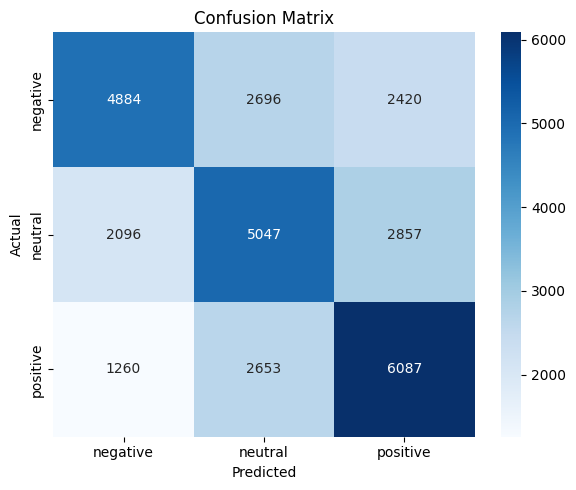


Misclassified examples: 13982 out of 30000 (46.6%)

Sample misclassifications:

Original: अशा ‘जॉनर’चा चित्रपट आंतरराष्ट्रीय चित्रपटप्रेमींसाठी नवा नसला तरी भारतीय रसिकां...
English:  Such 'Joner' film is not new to international cinema but is new to Indian jokes...
Gold: neutral -> Predicted: negative
Scores - Pos: 0.250, Neg: 0.417

Original: नाहीतर चित्रपटाला दीड स्टारच बरोबर आहेत...
English:  Otherwise the film has one and a half stars right...
Gold: negative -> Predicted: positive
Scores - Pos: 0.535, Neg: 0.129

Original: दुसर्‍या दिवशी मी माझ्या स्वत: च्या सामग्रीवर पूर्णपणे टांगलेले होते....
English:  The next day I was completely hanging on my own content....
Gold: negative -> Predicted: neutral
Scores - Pos: 0.125, Neg: 0.125

Original: असे दिसते की रॉस तिच्याशी ब्रेकअप करत आहे....
English:  Looks like a ross is breaking her....
Gold: negative -> Predicted: neutral
Scores - Pos: 0.000, Neg: 0.000

Original: ते बर होईल....
English:  That will be fine....
Gold: positive -> Pre

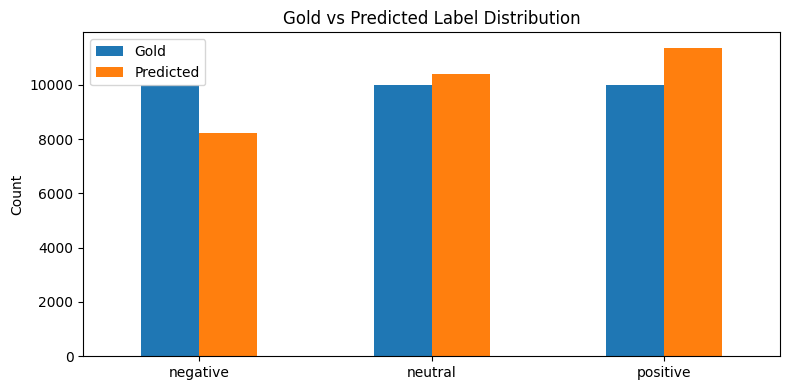


Evaluation completed. Metrics summary:
accuracy: 0.5339333333333334
evaluation_samples: 30000


{'accuracy': 0.5339333333333334,
 'evaluation_samples': 30000,
 'per_class': {'negative': {'precision': 0.5927184466019417,
   'recall': 0.4884,
   'f1': 0.5355263157894737,
   'support': 10000},
  'neutral': {'precision': 0.485475182762601,
   'recall': 0.5047,
   'f1': 0.4949009609727398,
   'support': 10000},
  'positive': {'precision': 0.5356388595564942,
   'recall': 0.6087,
   'f1': 0.5698371091555888,
   'support': 10000}}}

In [14]:
# =====================
# 5. Evaluation
# =====================

# Define valid sentiment labels
valid_labels = {'positive', 'negative', 'neutral'}

# Filter evaluation dataset to only rows with valid gold labels
_eval_df = merged[merged['label'].isin(valid_labels)].copy()
print(f"Evaluation rows: {_eval_df.shape[0]} / {merged.shape[0]}")

# Check if we have enough data for evaluation
if _eval_df.empty:
    print('No valid gold labels to evaluate.')
    print('Available labels in dataset:')
    print(merged['label'].value_counts(dropna=False))
    
    # Create dummy metrics for consistency
    metrics_summary = {
        'accuracy': 0.0,
        'note': 'No valid gold labels for evaluation',
        'per_class': {}
    }
    
elif len(_eval_df) < 3:
    print(f'Only {len(_eval_df)} evaluation samples - too few for meaningful evaluation.')
    metrics_summary = {
        'accuracy': 0.0,
        'note': 'Insufficient evaluation samples',
        'per_class': {}
    }
    
else:
    print('Performing evaluation...')
    
    gold = _eval_df['label']
    pred = _eval_df['predicted_label']
    
    # Check if predictions contain valid labels
    pred_labels_set = set(pred.unique())
    invalid_preds = pred_labels_set - valid_labels
    if invalid_preds:
        print(f"Warning: Found invalid predicted labels: {invalid_preds}")
        # Filter out invalid predictions
        valid_mask = pred.isin(valid_labels)
        _eval_df = _eval_df[valid_mask]
        gold = _eval_df['label']
        pred = _eval_df['predicted_label']
        print(f"Filtered to {len(_eval_df)} rows with valid predictions")
    
    if len(_eval_df) == 0:
        print('No valid predictions to evaluate.')
        metrics_summary = {'accuracy': 0.0, 'note': 'No valid predictions'}
    else:
        try:
            # Calculate metrics
            acc = accuracy_score(gold, pred)
            
            # Get unique labels present in both gold and pred for proper indexing
            present_labels = sorted(list(set(gold.unique()) | set(pred.unique())))
            present_labels = [lbl for lbl in present_labels if lbl in valid_labels]
            
            precision, recall, f1, support = precision_recall_fscore_support(
                gold, pred, labels=present_labels, zero_division=0
            )
            
            report = classification_report(gold, pred, digits=4, zero_division=0)
            cm = confusion_matrix(gold, pred, labels=present_labels)

            print(f"Accuracy: {acc:.4f}")
            print('\nClassification Report:')
            print(report)

            # Plot confusion matrix
            if len(present_labels) > 1:
                try:
                    fig, ax = plt.subplots(figsize=(6, 5))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                               xticklabels=present_labels, yticklabels=present_labels, ax=ax)
                    ax.set_xlabel('Predicted')
                    ax.set_ylabel('Actual')
                    ax.set_title('Confusion Matrix')
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"Could not create confusion matrix plot: {e}")

            # Error analysis
            errors = _eval_df[_eval_df['label'] != _eval_df['predicted_label']]
            print(f"\nMisclassified examples: {len(errors)} out of {len(_eval_df)} ({len(errors)/len(_eval_df)*100:.1f}%)")
            
            if len(errors) > 0:
                print("\nSample misclassifications:")
                error_cols = ['text', 'english_text', 'label', 'predicted_label', 'pos_score', 'neg_score']
                available_cols = [col for col in error_cols if col in errors.columns]
                
                sample_errors = errors[available_cols].head(5)
                for idx, row in sample_errors.iterrows():
                    print(f"\nOriginal: {row['text'][:80]}...")
                    if 'english_text' in row:
                        print(f"English:  {row['english_text'][:80]}...")
                    print(f"Gold: {row['label']} -> Predicted: {row['predicted_label']}")
                    if 'pos_score' in row and 'neg_score' in row:
                        print(f"Scores - Pos: {row['pos_score']:.3f}, Neg: {row['neg_score']:.3f}")
            
            # Label-wise analysis
            print("\nPer-label performance:")
            for i, lbl in enumerate(present_labels):
                if i < len(precision):
                    print(f"{lbl}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}")

            # Create metrics summary
            metrics_summary = {
                'accuracy': float(acc),
                'evaluation_samples': len(_eval_df),
                'per_class': {}
            }
            
            for i, lbl in enumerate(present_labels):
                if i < len(precision):
                    metrics_summary['per_class'][lbl] = {
                        'precision': float(precision[i]),
                        'recall': float(recall[i]),
                        'f1': float(f1[i]),
                        'support': int(support[i])
                    }
            
            # Add distribution comparison
            print("\nLabel distribution comparison:")
            gold_dist = gold.value_counts().sort_index()
            pred_dist = pred.value_counts().sort_index()
            
            dist_df = pd.DataFrame({
                'Gold': gold_dist,
                'Predicted': pred_dist
            }).fillna(0).astype(int)
            print(dist_df)
            
            # Simple visualization of distribution
            try:
                fig, ax = plt.subplots(figsize=(8, 4))
                dist_df.plot(kind='bar', ax=ax, rot=0)
                ax.set_title('Gold vs Predicted Label Distribution')
                ax.set_ylabel('Count')
                ax.legend()
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not create distribution plot: {e}")
                
        except Exception as e:
            print(f"Error during evaluation: {e}")
            metrics_summary = {
                'accuracy': 0.0,
                'error': str(e),
                'per_class': {}
            }

print(f"\nEvaluation completed. Metrics summary:")
for key, value in metrics_summary.items():
    if key != 'per_class':
        print(f"{key}: {value}")

metrics_summary

## Visualization
We generate word clouds for each predicted sentiment and a bar plot comparing gold vs predicted distribution.

Generating visualizations...
Predicted label distribution: {'positive': 12559, 'neutral': 9189, 'negative': 8252}
Saved word cloud for positive to output\wordcloud_positive.png
Saved word cloud for negative to output\wordcloud_negative.png
Saved word cloud for neutral to output\wordcloud_neutral.png


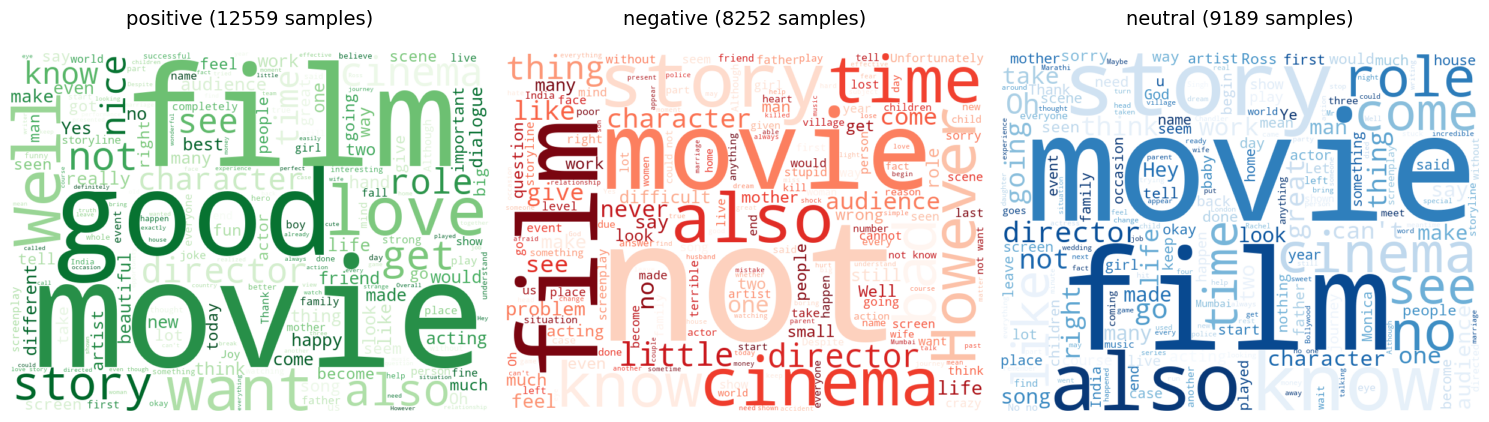


Creating label distribution plot...


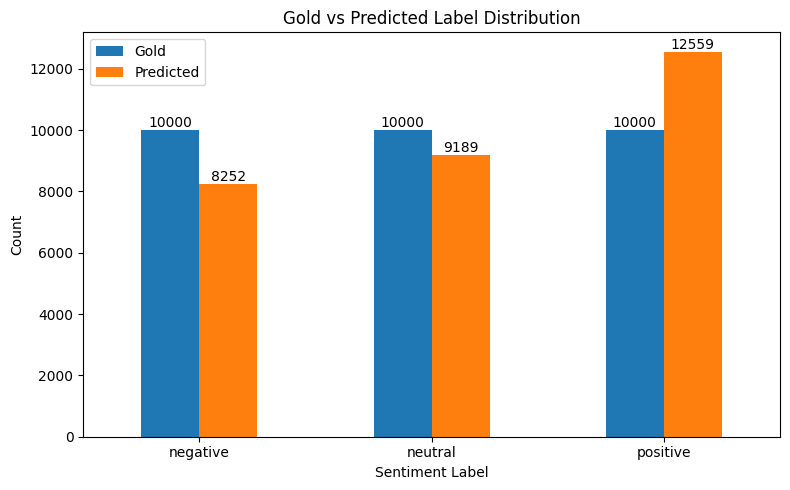


Creating sentiment score distributions...


C:\Users\ashpa\AppData\Local\Temp\ipykernel_5788\3671156524.py:176: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged[['pos_score', 'neg_score']].hist(ax=ax2, bins=20, alpha=0.7)


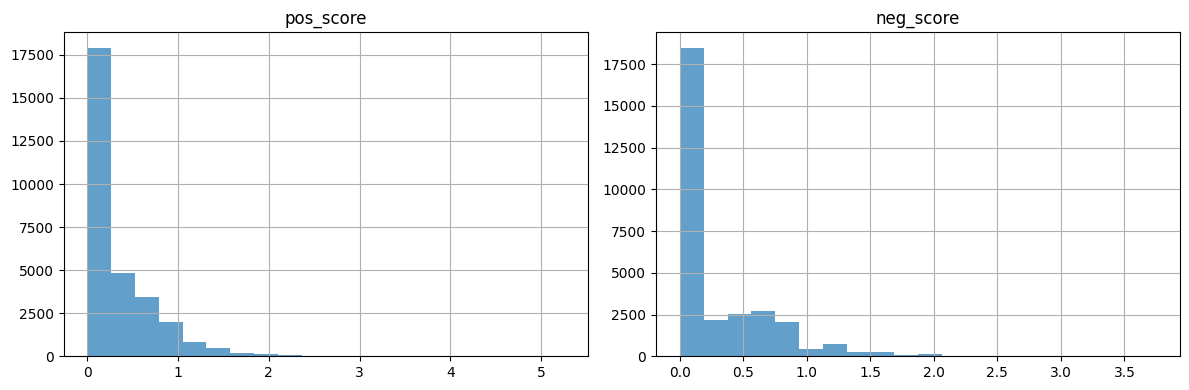


Visualization completed!
Word cloud files saved: 3
  positive: output\wordcloud_positive.png
  negative: output\wordcloud_negative.png
  neutral: output\wordcloud_neutral.png


{'positive': 'output\\wordcloud_positive.png',
 'negative': 'output\\wordcloud_negative.png',
 'neutral': 'output\\wordcloud_neutral.png'}

In [8]:
# =====================
# 6. Visualization
# =====================

import warnings
warnings.filterwarnings('ignore', message='Glyph.*missing from current font')

print("Generating visualizations...")

# WordClouds by predicted label
wc_dir = OUTPUT_DIR
wc_paths = {}

# Define colors and labels for visualization
sentiment_config = [
    ('positive', 'Greens', '#2d8659'),
    ('negative', 'Reds', '#c41e3a'), 
    ('neutral', 'Blues', '#2e86ab')
]

try:
    predicted_labels = merged['predicted_label'].value_counts()
    print(f"Predicted label distribution: {dict(predicted_labels)}")

    if len(predicted_labels) == 0:
        print("No predicted labels found. Skipping word cloud generation.")
        wc_paths = {}
    else:
        # Create word clouds for each sentiment
        num_labels = len([label for label, _, _ in sentiment_config if label in predicted_labels])
        if num_labels > 0:
            fig, axes = plt.subplots(1, max(3, num_labels), figsize=(15, 5))
            if num_labels == 1:
                axes = [axes]
            elif num_labels == 2:
                axes = axes[:2]

            for i, (label, cmap, color) in enumerate(sentiment_config):
                ax = axes[i] if i < len(axes) else None
                if ax is None:
                    continue

                subset = merged[merged['predicted_label'] == label]
                if len(subset) == 0 or label not in predicted_labels:
                    ax.set_title(f"No data for {label}")
                    ax.axis('off')
                    continue

                # Collect Marathi text directly now
                marathi_texts = subset['text'].dropna().astype(str)
                text_blob = ' '.join(marathi_texts)

                if not text_blob.strip():
                    ax.set_title(f"No valid text for {label}")
                    ax.axis('off')
                    continue

                try:
                    wc = WordCloud(
                        width=800,
                        height=600,
                        background_color='white',
                        colormap=cmap,
                        # Note: EN_STOPWORDS still removes English stopwords if any; Marathi stopwords not included here
                        stopwords=EN_STOPWORDS,
                        max_words=200,
                        relative_scaling=0.5,
                        min_font_size=10,
                        font_path=str(Path('fonts') / 'NotoSansDevanagari-Regular.ttf') if Path('fonts/NotoSansDevanagari-Regular.ttf').exists() else None
                    ).generate(text_blob)

                    ax.imshow(wc, interpolation='bilinear')
                    ax.axis('off')
                    ax.set_title(f"{label} ({len(subset)} samples)", fontsize=14, pad=20)

                    out_path = wc_dir / f'wordcloud_{label}_marathi.png'
                    try:
                        wc.to_file(str(out_path))
                        wc_paths[label] = str(out_path)
                        print(f"Saved word cloud for {label} to {out_path}")
                    except Exception as e:
                        print(f"Could not save word cloud for {label}: {e}")

                except Exception as e:
                    print(f"Error creating word cloud for {label}: {e}")
                    ax.set_title(f"Error: {label}")
                    ax.axis('off')

            for i in range(num_labels, len(axes)):
                if i < len(axes):
                    axes[i].axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("No valid sentiment labels found for word cloud generation.")

except Exception as e:
    print(f"Error during word cloud generation: {e}")
    wc_paths = {}

# Label distribution bar plot
try:
    print("\nCreating label distribution plot...")

    fig, ax = plt.subplots(figsize=(8, 5))

    count_pred = merged['predicted_label'].value_counts()

    if 'label' in merged.columns and not merged['label'].isna().all():
        count_gold = merged['label'].value_counts()
        all_labels = sorted(set(count_gold.index).union(count_pred.index))

        bar_df = pd.DataFrame({
            'Gold': [count_gold.get(l, 0) for l in all_labels],
            'Predicted': [count_pred.get(l, 0) for l in all_labels]
        }, index=all_labels)

        bar_df.plot(kind='bar', ax=ax, rot=0, color=['#1f77b4', '#ff7f0e'])
        ax.set_title('Gold vs Predicted Label Distribution (Marathi Lexicon)')
        ax.legend()
    else:
        count_pred.plot(kind='bar', ax=ax, rot=0, color='#ff7f0e')
        ax.set_title('Predicted Label Distribution (Marathi Lexicon)')

    ax.set_ylabel('Count')
    ax.set_xlabel('Sentiment Label')

    for i, patch in enumerate(ax.patches):
        height = patch.get_height()
        if height > 0:
            ax.text(patch.get_x() + patch.get_width()/2., height + 0.5,
                   f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error creating label distribution plot: {e}")

# Additional visualization: Score distribution
try:
    print("\nCreating sentiment score distributions...")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ax1 = axes[0]
    colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
    for label in merged['predicted_label'].unique():
        if pd.notna(label):
            subset = merged[merged['predicted_label'] == label]
            ax1.scatter(subset['pos_score'], subset['neg_score'], 
                       c=colors.get(label, 'gray'), label=label, alpha=0.6)

    ax1.set_xlabel('Positive Score')
    ax1.set_ylabel('Negative Score')
    ax1.set_title('Sentiment Score Distribution (Marathi Lexicon)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = axes[1]
    merged[['pos_score', 'neg_score']].hist(ax=ax2, bins=20, alpha=0.7)
    ax2.set_title('Score Histograms (Marathi Lexicon)')
    ax2.set_xlabel('Score Value')
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error creating score distribution plots: {e}")

print(f"\nVisualization completed!")
print(f"Word cloud files saved: {len(wc_paths)}")
for label, path in wc_paths.items():
    print(f"  {label}: {path}")

wc_paths

### English Word Clouds by Predicted Sentiment

The following visualizations mirror the Marathi word clouds but use the translated English text (`english_text`). We filter placeholder values and apply English stopwords for cleaner clouds. Files are saved to `output/wordcloud_{label}_english.png` and recorded in `wc_paths`.

In [ ]:
# Per-label English Word Clouds (using translated `english_text`)
from wordcloud import WordCloud

try:
    wc_paths
except NameError:
    wc_paths = {}

if 'english_text' not in merged.columns:
    print("english_text column missing; skipping English word clouds.")
else:
    predicted_labels = merged['predicted_label'].value_counts()
    if len(predicted_labels) == 0:
        print("No predicted labels found. Skipping English word cloud generation.")
    else:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        if not isinstance(axes, (list, np.ndarray)):
            axes = [axes]

        sentiment_config = [
            ('positive', 'Greens'),
            ('negative', 'Reds'),
            ('neutral',  'Blues')
        ]

        for i, (label, cmap) in enumerate(sentiment_config):
            ax = axes[i]
            subset = merged[merged['predicted_label'] == label]
            if len(subset) == 0 or label not in predicted_labels:
                ax.set_title(f"No data for {label}")
                ax.axis('off')
                continue

            english_texts = subset['english_text'].replace({
                '<not_translated>': '', '<no_translation_available>': ''
            }).dropna().astype(str)
            text_blob = ' '.join(english_texts)

            if not text_blob.strip():
                ax.set_title(f"No valid English text for {label}")
                ax.axis('off')
                continue

            try:
                wc = WordCloud(
                    width=800, height=600, background_color='white',
                    colormap=cmap, stopwords=STOPWORDS,
                    max_words=200, relative_scaling=0.5, min_font_size=10
                ).generate(text_blob)

                ax.imshow(wc, interpolation='bilinear')
                ax.axis('off')
                ax.set_title(f"{label} (English, {len(subset)} samples)", fontsize=14, pad=20)

                out_path = OUTPUT_DIR / f'wordcloud_{label}_english.png'
                try:
                    wc.to_file(str(out_path))
                    wc_paths[f'{label}_english'] = str(out_path)
                    print(f"Saved English word cloud for {label} to {out_path}")
                except Exception as e:
                    print(f"Could not save English word cloud for {label}: {e}")

            except Exception as e:
                print(f"Error creating English word cloud for {label}: {e}")
                ax.set_title(f"Error: {label}")
                ax.axis('off')

        plt.tight_layout()
        plt.show()

## Balanced Word Clouds (Marathi and English)

To visually compare salient tokens across sentiments without frequency bias, we create balanced word clouds:
- Sample an equal number of tokens from positive, negative, and neutral sets
- Color mapping: Positive = green, Negative = red, Neutral = blue
- Generate two clouds: Marathi (Devanagari font) and English

Outputs are saved into `output/` and their paths appended to the `wc_paths` map.

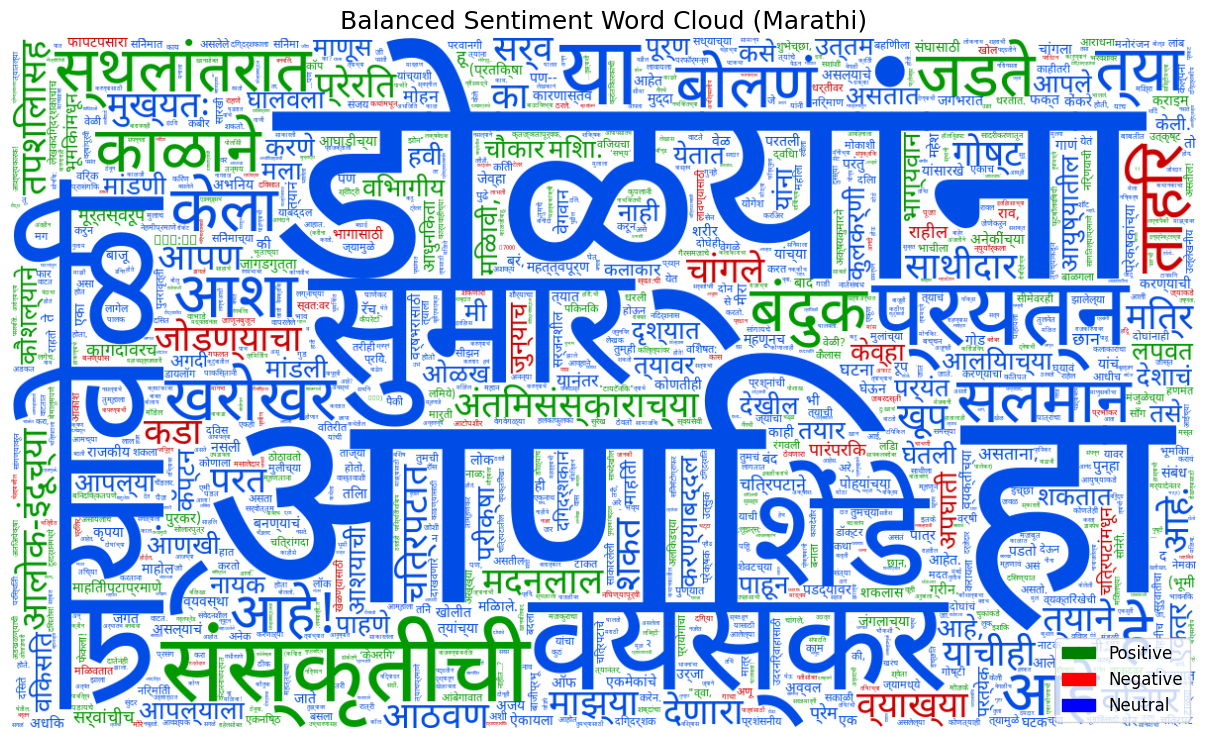

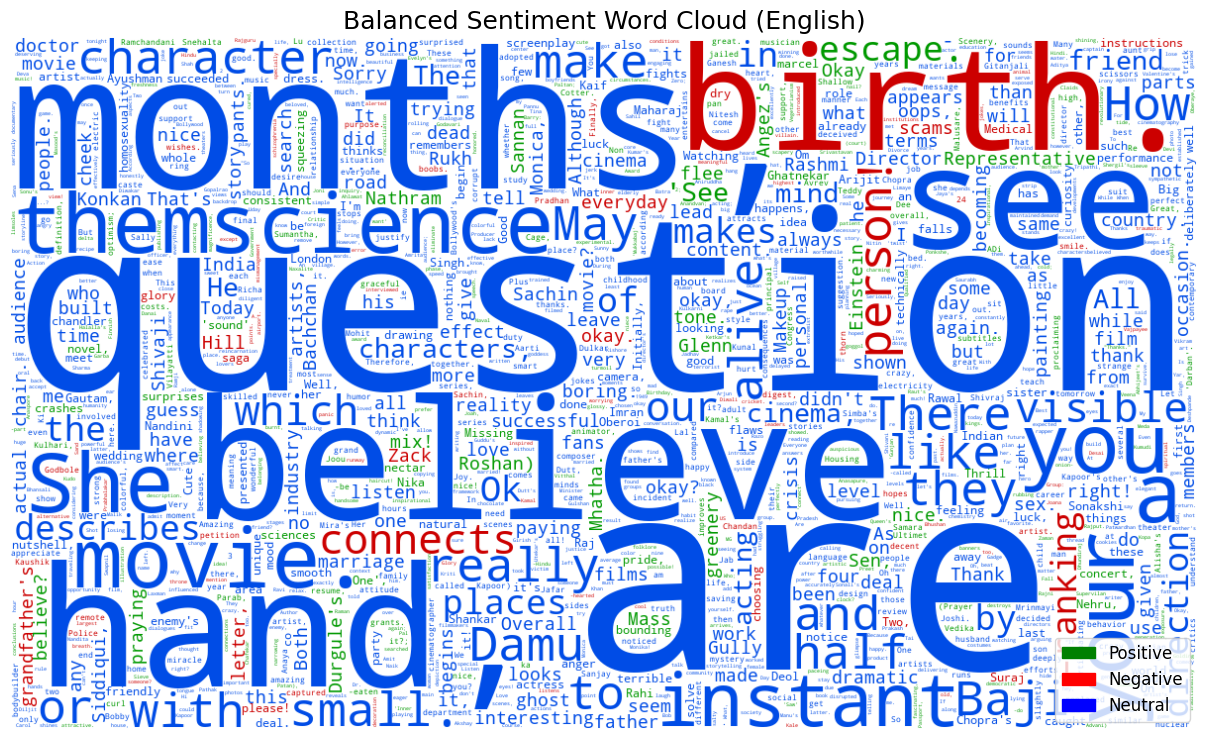

Balanced word cloud paths: output\wordcloud_balanced_marathi.png output\wordcloud_balanced_english.png


In [19]:
# Balanced Word Clouds: Marathi + English (equalized sizes per sentiment)
import random
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS

try:
    wc_paths
except NameError:
    wc_paths = {}

COLORS = {"positive": "hsl(120, 100%, 30%)",  # green
          "negative": "hsl(0, 100%, 40%)",    # red
          "neutral":  "hsl(220, 100%, 45%)"}  # blue

random.seed(SEED if 'SEED' in globals() else 42)

# Determine font path (for Marathi)
_font_candidates = [
    Path('fonts')/ 'NotoSansDevanagari-Regular.ttf',
    Path.cwd() / 'NotoSansDevanagari-Regular.ttf'
]
font_path = None
for _p in _font_candidates:
    try:
        if _p.exists():
            font_path = str(_p)
            break
    except Exception:
        pass

label_col = 'predicted_label'
text_col_mar = 'text'
text_col_eng = 'english_text'

if label_col not in merged.columns:
    print("predicted_label column missing; skipping balanced word clouds.")
else:
    def collect_tokens(series):
        return [t.strip() for t in ' '.join(series.dropna().astype(str)).split() if t.strip()]

    pos_mar = collect_tokens(merged.loc[merged[label_col]== 'positive', text_col_mar])
    neg_mar = collect_tokens(merged.loc[merged[label_col]== 'negative', text_col_mar])
    neu_mar = collect_tokens(merged.loc[merged[label_col]== 'neutral',  text_col_mar])

    if text_col_eng in merged.columns:
        valid_eng = merged[text_col_eng].replace({
            '<not_translated>': '', '<no_translation_available>': ''
        })
        pos_eng = collect_tokens(valid_eng[merged[label_col]== 'positive'])
        neg_eng = collect_tokens(valid_eng[merged[label_col]== 'negative'])
        neu_eng = collect_tokens(valid_eng[merged[label_col]== 'neutral'])
    else:
        pos_eng = neg_eng = neu_eng = []

    def build_balanced_freq(pos_list, neg_list, neu_list):
        min_len = min(len(pos_list), len(neg_list), len(neu_list))
        if min_len == 0:
            return None, None
        pos_sample = random.sample(pos_list, min_len)
        neg_sample = random.sample(neg_list, min_len)
        neu_sample = random.sample(neu_list, min_len)
        freqs = {}
        color_map = {}
        for w in pos_sample:
            freqs[w] = 1
            color_map[w] = 'positive'
        for w in neg_sample:
            freqs[w] = 1
            color_map[w] = 'negative'
        for w in neu_sample:
            freqs[w] = 1
            color_map[w] = 'neutral'
        return freqs, color_map

    def color_func_factory(color_map):
        def _color(word, **kwargs):
            return COLORS.get(color_map.get(word, 'neutral'), COLORS['neutral'])
        return _color

    def gen_and_show(freqs, color_map, title, out_name, use_font=None, stopwords=None):
        wc = WordCloud(
            width=1200, height=700, background_color='white',
            font_path=use_font, stopwords=stopwords or STOPWORDS,
            prefer_horizontal=0.9, max_words=3*len(freqs) if freqs else 200,
            color_func=color_func_factory(color_map)
        ).generate_from_frequencies(freqs)
        plt.figure(figsize=(16, 9))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=18)
        pos_patch = mpatches.Patch(color='green', label='Positive')
        neg_patch = mpatches.Patch(color='red', label='Negative')
        neu_patch = mpatches.Patch(color='blue', label='Neutral')
        plt.legend(handles=[pos_patch, neg_patch, neu_patch], loc='lower right', fontsize=12)
        plt.show()
        try:
            out_file = OUTPUT_DIR / out_name
            wc.to_file(str(out_file))
            return str(out_file)
        except Exception as e:
            print(f"Could not save {out_name}: {e}")
            return None

    # Marathi balanced
    freqs_mar, cmap_mar = build_balanced_freq(pos_mar, neg_mar, neu_mar)
    if freqs_mar:
        out_mar = gen_and_show(
            freqs_mar, cmap_mar,
            'Balanced Sentiment Word Cloud (Marathi)',
            'wordcloud_balanced_marathi.png', use_font=font_path,
            stopwords=EN_STOPWORDS
        )
        if out_mar:
            wc_paths['balanced_marathi'] = out_mar
    else:
        print('Skipping Marathi balanced word cloud (insufficient tokens per class).')

    # English balanced
    freqs_eng, cmap_eng = build_balanced_freq(pos_eng, neg_eng, neu_eng)
    if freqs_eng and sum(len(x) for x in [pos_eng, neg_eng, neu_eng])>0:
        out_eng = gen_and_show(
            freqs_eng, cmap_eng,
            'Balanced Sentiment Word Cloud (English)',
            'wordcloud_balanced_english.png', use_font=None,
            stopwords=STOPWORDS
        )
        if out_eng:
            wc_paths['balanced_english'] = out_eng
    else:
        print('Skipping English balanced word cloud (insufficient tokens per class).')

print('Balanced word cloud paths:', wc_paths.get('balanced_marathi'), wc_paths.get('balanced_english'))

## Save Results
Persist processed dataset, metrics (JSON), word clouds, and translation cache to the `output/` directory.

In [18]:
# =====================
# 7. Save Artifacts
# =====================

print("Saving artifacts and results...")

# Ensure output directory exists
try:
    OUTPUT_DIR.mkdir(exist_ok=True)
    print(f"Output directory: {OUTPUT_DIR}")
except Exception as e:
    print(f"Warning: Could not create output directory: {e}")

saved_files = {}

# 1. Save main results CSV
try:
    available_cols = list(merged.columns)
    desired_cols = ['text', 'label', 'predicted_label', 'pos_score', 'neg_score', 'obj_score', 'translation_ok', 'source']
    results_cols = [col for col in desired_cols if col in available_cols]

    results_path = OUTPUT_DIR / 'merged_sentiment_results.csv'
    merged[results_cols].to_csv(results_path, index=False, encoding='utf-8')
    saved_files['results_csv'] = str(results_path)
    print(f"✓ Saved results CSV ({len(merged)} rows, {len(results_cols)} columns): {results_path}")
except Exception as e:
    print(f"✗ Error saving results CSV: {e}")

# 2. Save metrics summary JSON
try:
    metrics_path = OUTPUT_DIR / 'metrics_summary.json'

    if 'metrics_summary' in globals() and metrics_summary:
        enhanced_metrics = metrics_summary.copy()
    else:
        enhanced_metrics = {}

    enhanced_metrics.update({
        'dataset_info': {
            'total_samples': len(merged),
            'translation_success_rate': merged['translation_ok'].sum() / len(merged) if 'translation_ok' in merged.columns else 0,
            'predicted_distribution': dict(merged['predicted_label'].value_counts()),
            'processing_timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'scoring_source': 'Marathi WordNet lexicon'
        }
    })

    with open(metrics_path, 'w', encoding='utf-8') as f:
        json.dump(enhanced_metrics, f, ensure_ascii=False, indent=2)
    saved_files['metrics_json'] = str(metrics_path)
    print(f"✓ Saved metrics JSON: {metrics_path}")
except Exception as e:
    print(f"✗ Error saving metrics JSON: {e}")

# 3. Save confusion matrix plot (if evaluation was performed)
try:
    if '_eval_df' in globals() and not _eval_df.empty and len(_eval_df) > 0:
        cm_plot_path = OUTPUT_DIR / 'confusion_matrix.png'

        gold_labels = _eval_df['label'].unique()
        pred_labels = _eval_df['predicted_label'].unique()
        all_labels = sorted(list(set(gold_labels) | set(pred_labels)))

        if len(all_labels) > 1:
            cm = confusion_matrix(_eval_df['label'], _eval_df['predicted_label'], labels=all_labels)

            fig, ax = plt.subplots(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=all_labels, yticklabels=all_labels, ax=ax)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            ax.set_title('Confusion Matrix (Marathi Lexicon)')
            plt.tight_layout()
            fig.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
            plt.close(fig)
            saved_files['confusion_matrix'] = str(cm_plot_path)
            print(f"✓ Saved confusion matrix: {cm_plot_path}")
        else:
            print("⚠ Skipped confusion matrix (insufficient label diversity)")
    else:
        print("⚠ Skipped confusion matrix (no evaluation data)")
except Exception as e:
    print(f"✗ Error saving confusion matrix: {e}")

# 4. Save dataset statistics
try:
    stats_path = OUTPUT_DIR / 'dataset_statistics.json'

    stats = {
        'overview': {
            'total_samples': len(merged),
            'unique_texts': merged['text'].nunique() if 'text' in merged.columns else 0,
            'sources': dict(merged['source'].value_counts()) if 'source' in merged.columns else {},
        },
        'labels': {
            'gold_distribution': dict(merged['label'].value_counts(dropna=False)) if 'label' in merged.columns else {},
            'predicted_distribution': dict(merged['predicted_label'].value_counts()) if 'predicted_label' in merged.columns else {}
        },
        'sentiment_scores': {
            'positive_score_stats': {
                'mean': float(merged['pos_score'].mean()) if 'pos_score' in merged.columns else 0,
                'std': float(merged['pos_score'].std()) if 'pos_score' in merged.columns else 0,
                'min': float(merged['pos_score'].min()) if 'pos_score' in merged.columns else 0,
                'max': float(merged['pos_score'].max()) if 'pos_score' in merged.columns else 0
            },
            'negative_score_stats': {
                'mean': float(merged['neg_score'].mean()) if 'neg_score' in merged.columns else 0,
                'std': float(merged['neg_score'].std()) if 'neg_score' in merged.columns else 0,
                'min': float(merged['neg_score'].min()) if 'neg_score' in merged.columns else 0,
                'max': float(merged['neg_score'].max()) if 'neg_score' in merged.columns else 0
            }
        }
    }

    with open(stats_path, 'w', encoding='utf-8') as f:
        json.dump(stats, f, ensure_ascii=False, indent=2)
    saved_files['dataset_stats'] = str(stats_path)
    print(f"✓ Saved dataset statistics: {stats_path}")
except Exception as e:
    print(f"✗ Error saving dataset statistics: {e}")

# 5. Ensure translation cache is saved (kept for reproducibility though not needed for scoring)
try:
    if 'translation_cache' in globals() and 'save_cache' in globals():
        if save_cache(translation_cache, TRANSLATION_CACHE_PATH):
            saved_files['translation_cache'] = str(TRANSLATION_CACHE_PATH)
            print(f"✓ Final translation cache saved: {TRANSLATION_CACHE_PATH}")
        else:
            print("✗ Failed to save translation cache")
    else:
        print("⚠ Translation cache not available")
except Exception as e:
    print(f"✗ Error saving translation cache: {e}")

# 6. Include word cloud paths
if 'wc_paths' in globals() and wc_paths:
    saved_files['word_clouds'] = wc_paths
    print(f"✓ Word cloud files ({len(wc_paths)} files):")
    for label, path in wc_paths.items():
        print(f"    {label}: {path}")

# 7. Save file index for reference
try:
    file_index_path = OUTPUT_DIR / 'saved_files_index.json'
    with open(file_index_path, 'w', encoding='utf-8') as f:
        json.dump(saved_files, f, ensure_ascii=False, indent=2)
    print(f"✓ Saved file index: {file_index_path}")
except Exception as e:
    print(f"✗ Error saving file index: {e}")

print(f"\n{'='*50}")
print("ARTIFACTS SAVED SUCCESSFULLY")
print(f"{'='*50}")
print(f"Total files saved: {len(saved_files)}")
for artifact_type, path in saved_files.items():
    if isinstance(path, dict):
        print(f"  {artifact_type}: {len(path)} files")
    else:
        print(f"  {artifact_type}: {path}")

print(f"\nAll artifacts saved to: {OUTPUT_DIR}")
print("Processing completed successfully!")

saved_files

Saving artifacts and results...
Output directory: output
✓ Saved results CSV (30000 rows, 8 columns): output\merged_sentiment_results.csv
✗ Error saving metrics JSON: Object of type int64 is not JSON serializable
✓ Saved confusion matrix: output\confusion_matrix.png
✗ Error saving dataset statistics: Object of type int64 is not JSON serializable
✓ Saved confusion matrix: output\confusion_matrix.png
✗ Error saving dataset statistics: Object of type int64 is not JSON serializable
✓ Final translation cache saved: translation_cache.json
✓ Word cloud files (5 files):
    positive: output\wordcloud_positive.png
    negative: output\wordcloud_negative.png
    neutral: output\wordcloud_neutral.png
    balanced_marathi: output\wordcloud_balanced_marathi.png
    balanced_english: output\wordcloud_balanced_english.png
✓ Saved file index: output\saved_files_index.json

ARTIFACTS SAVED SUCCESSFULLY
Total files saved: 4
  results_csv: output\merged_sentiment_results.csv
  confusion_matrix: output\co

{'results_csv': 'output\\merged_sentiment_results.csv',
 'confusion_matrix': 'output\\confusion_matrix.png',
 'translation_cache': 'translation_cache.json',
 'word_clouds': {'positive': 'output\\wordcloud_positive.png',
  'negative': 'output\\wordcloud_negative.png',
  'neutral': 'output\\wordcloud_neutral.png',
  'balanced_marathi': 'output\\wordcloud_balanced_marathi.png',
  'balanced_english': 'output\\wordcloud_balanced_english.png'}}

## Balanced Word Clouds (Marathi and English)

To visually compare salient tokens across sentiments without frequency bias, we create balanced word clouds:
- Sample an equal number of tokens from positive, negative, and neutral sets
- Color mapping: Positive = green, Negative = red, Neutral = blue
- Generate two clouds: Marathi (Devanagari font) and English

Outputs are saved into `output/` and their paths appended to the `wc_paths` map.

## Conclusion
This notebook established a transparent rule-based baseline for Marathi tweet/movie review sentiment by leveraging machine translation and SentiWordNet.

### Key Takeaways
- Translation quality directly impacts sentiment scoring
- SentiWordNet works better on standard English vocabulary; domain / slang terms are often OOV
- Neutral classification absorbs ambiguous low-margin cases

### Potential Improvements
1. Use better translation (IndicTrans2 or offline Marian models) to reduce noise
2. Lemmatize tokens before SentiWordNet lookup to improve coverage
3. Incorporate negation scope detection (e.g., reversing polarity within window after negation)
4. Add weighting by synset rank or average top-K synsets instead of first-sense heuristic
5. Compare with ML baselines: Logistic Regression / SVM using TF-IDF over English translations
6. Fine-tune transformer models (IndicBERT, mBERT, MuRIL) directly on Marathi without translation
7. Perform error clustering to identify systematic mistranslations

### Next Steps
You can now add a new section that trains a supervised classifier and compares metrics, or wrap this pipeline into a reusable Python module.

---
End of notebook.

In [1]:
import torch
print(torch.cuda.is_available())

True
